## PreTraining on Unlabeled Data the GPT Model

In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tiktoken

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

In [4]:

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [5]:
class LayerNormalization(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # bessel correction n instead of (n -1 )
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # prevent divide by zero
        return norm_x * self.scale + self.shift # two learnable parameters model learns during training

In [6]:
class GeLU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [7]:
class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embedding_size"], 4 * cfg["embedding_size"]),
            GeLU(),
            nn.Linear(4 * cfg["embedding_size"], cfg["embedding_size"])
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_Query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.size() # batch, num_tokens, dimension

        keys = self.W_Key(x)
        queries = self.W_Query(x)
        values = self.W_Value(x)
        # We change last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim) to split the d_out in num_heads part
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1) # we transpose the last two dimension as the first two will be broadcased

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores.masked_fill_(mask_bool, float("-inf"))

        attention_weights = torch.nn.functional.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)

        attention_weights = self.dropout(attention_weights)

        context_vectors = (attention_weights @ values).transpose(1, 2) # (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)

        context_vectors = context_vectors.contiguous().view(b, num_tokens, self.d_out)
        context_vectors = self.out_proj(context_vectors)

        return context_vectors

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["embedding_size"],
            d_out=cfg["embedding_size"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["embedding_size"])
        self.norm2 = LayerNormalization(cfg["embedding_size"])
        self.drop_skip = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        skip = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_skip(x)
        x = x + skip

        skip = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_skip(x)
        x = x + skip

        return x

In [10]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embedding_size"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embedding_size"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNormalization(cfg["embedding_size"])
        self.out_head = nn.Linear(cfg["embedding_size"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "embedding_size": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [12]:
model = GPTModel(GPT_CONFIG_124M)

## Utils Function

In [13]:
def generate_text_sample(model, idx, max_new_tokens, context_size):
    """
    Generates a new token in autoregressive manner given a seed token

    Args:
       - model: The GPT Model
       - idx: The seed text token ids
       - max_new_tokens: The maximum number of tokens we want to generate
       - context_size: The number of tokens to consider at one time during inference
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # get all batch, and only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :] # get the logits for only the last token which is what we used to predict the next token
        probs = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat([idx, idx_next], dim=1)

    return idx

In [14]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

In [15]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

In [16]:
token_ids = generate_text_sample(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves youpowderfocusedbasketball songs Publicationgeoningitives Problems caste playlist


## Model Generalization Error

In [17]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [18]:
with torch.no_grad():
  logits = model(inputs)


probabilities = torch.softmax(logits, dim=-1)
print(probabilities.shape)

torch.Size([2, 3, 50257])


In [19]:
token_ids = torch.argmax(probabilities, dim=-1, keepdim=True)
print(f"Token Ids: {token_ids}")

Token Ids: tensor([[[40849],
         [ 2311],
         [35135]],

        [[29180],
         [50014],
         [15008]]])


In [20]:
print(f"Targets of 1st batch: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs of 1st batch: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets of 1st batch:  effort moves you
Outputs of 1st batch:  Tape Sen adapting


In [21]:
text_idx = 0
target_probs_1 = probabilities[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_1)

Text 1: tensor([9.1944e-06, 1.7849e-05, 1.4937e-05])


In [22]:
text_idx = 1
target_probas_2 = probabilities[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([2.4133e-05, 3.1309e-05, 2.2906e-05])


### Log Likelihood

The goal of the training is to maximize these probabilities and get as close to 1.

In [23]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probs_1, target_probas_2)))
print(log_probas)

tensor([-11.5969, -10.9335, -11.1116, -10.6319, -10.3716, -10.6841])


In [24]:
torch.log(torch.tensor(0.01))

tensor(-4.6052)

In [25]:
average_log_probabilities = torch.mean(log_probas)
print(average_log_probabilities) # calculation of average log likelihood

tensor(-10.8883)


In [26]:
# negative log likelihood
negative_log_likelihood = -1 * average_log_probabilities
print(negative_log_likelihood)

tensor(10.8883)


The common practice is to minimize the negative log likelihood as close to 0

In [27]:
print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [28]:
tensor_a = torch.tensor([[[1,2,3],
                          [4,5,6]],
                         [[9,8,9],
                         [2,1,4]]])
tensor_b = torch.tensor([[900,800],
                         [200,400]])

tensor_a.shape, tensor_b.shape

(torch.Size([2, 2, 3]), torch.Size([2, 2]))

In [29]:
tensor_a_flat = tensor_a.flatten(start_dim=0, end_dim=1)
tensor_b_flat = tensor_b.flatten(0, 1)

tensor_a, tensor_a_flat, tensor_b, tensor_b_flat

(tensor([[[1, 2, 3],
          [4, 5, 6]],
 
         [[9, 8, 9],
          [2, 1, 4]]]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [9, 8, 9],
         [2, 1, 4]]),
 tensor([[900, 800],
         [200, 400]]),
 tensor([900, 800, 200, 400]))

In [30]:
logits_flat = logits.flatten(start_dim=0, end_dim=1)
targets_flat = targets.flatten()
print(f"Flat logits shape: {logits_flat.shape}")
print(f"Flat targets shape: {targets_flat.shape}")

Flat logits shape: torch.Size([6, 50257])
Flat targets shape: torch.Size([6])


In [31]:
targets, targets_flat

(tensor([[ 3626,  6100,   345],
         [ 1107,   588, 11311]]),
 tensor([ 3626,  6100,   345,  1107,   588, 11311]))

In [32]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8883)


Here `PyTorch` will handle the conversion of logits to softmax and then calculate the negative log likelihood for use so we just need to send the probabilities of predicted tokens i.e [6, vocab_size] and the actual target ids [6].

### Perplexity
It is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling.

It can provide a more interpretable way to understand the uncertainity of the model in predicting the next token in a sequence.

In [33]:
perplexity = torch.exp(loss)
perplexity

tensor(53545.6797)

## Calculation of validation and Traning error

In [34]:
with open("./the-verdict.txt", "r", encoding="utf-8") as f:
  text = f.read()

In [35]:
total_characters = len(text)
total_tokens = len(tokenizer.encode(text))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [36]:
train_ratio = 0.90
split_idx = int(total_characters * train_ratio)
train_data = text[:split_idx]
val_data = text[split_idx:]

In [37]:
from torch.utils.data import Dataset, DataLoader

class DatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        """create a dataset from the txt"""
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride): # stride is for overlapping
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
            return len(self.input_ids)

    def __getitem__(self, idx):
            return self.input_ids[idx], self.target_ids[idx]

In [38]:
def create_dataloaderV1(text, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    # initializing tokenizer
    tokenier = tiktoken.get_encoding("gpt2")

    dataset = DatasetV1(text, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size, shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [39]:
torch.manual_seed(123)

train_loader = create_dataloaderV1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloaderV1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [40]:
# Sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [41]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


## Calculate the batch generalization error

In [42]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch, target_batch = input_batch.to(device), target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
  return loss

In [43]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss = total_loss + loss.item()
    else:
      break
  return total_loss / num_batches

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

  print(f"Train loss: {train_loss:.3f}")
  print(f"Validation loss: {val_loss:.3f}")

Train loss: 10.999
Validation loss: 10.974


## Traning Model

In [46]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
  model.train()
  return train_loss, val_loss

In [52]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_sample(model, encoded, max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

In [53]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()

      loss = calc_loss_batch(input_batch, target_batch, model, device)

      loss.backward()

      optimizer.step()

      tokens_seen += input_batch.numel()

      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
            model,
            train_loader,
            val_loader,
            device,
            eval_iter
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Epoch: {epoch} (Step: {global_step:06d}): Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

    generate_and_print_sample(
        model, tokenizer, device, start_context
    )

  return train_losses, val_losses, track_tokens_seen


In [54]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Epoch: 0 (Step: 000000): Train loss: 9.818, Val loss: 9.930
Epoch: 0 (Step: 000005): Train loss: 8.066, Val loss: 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Epoch: 1 (Step: 000010): Train loss: 6.623, Val loss: 7.053
Epoch: 1 (Step: 000015): Train loss: 6.047, Val loss: 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Epoch: 2 (Step: 000020): Train loss: 5.532, Val loss: 6.507
Epoch: 2 (Step: 000025): Train loss: 5.399, Val loss: 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Epoch: 3 (Step: 000030): Train loss: 4.895, Val loss: 6.280
Epoch: 3 (Step: 000035): Train loss: 4.648, Val loss: 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Epoch: 4 (Step: 000040): Train loss: 4.023, Val loss: 6.165
Every

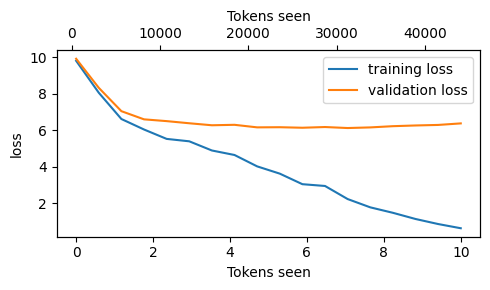

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_losses, label="training loss")
  ax1.plot(epochs_seen, val_losses, label="validation loss")
  ax1.set_xlabel("Tokens seen")
  ax1.set_ylabel("loss")
  ax1.legend()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


## Decoding strategies to control randomness

In [59]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear(in_features=768, out_features=768, bias=False)
        (W_Key): Linear(in_features=768, out_features=768, bias=False)
        (W_Value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Line

In [60]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_sample(model, text_to_token_ids("Every effort moves you", tokenizer), 100, GPT_CONFIG_124M["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"

He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I couldn't look at that thing--couldn't face it. But I had given up his painting because he had married her. I dashed at the canvas furiously, and tried some of my bravura tricks. I was when I got Mrs. St


## Temperature Scaling

In [61]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
     [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.88]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [77]:
probas

tensor([6.0884e-02, 1.6306e-03, 1.0016e-04, 5.7190e-01, 3.4177e-03, 1.3252e-04,
        1.0116e-04, 3.5744e-01, 4.3884e-03])

In [76]:
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [85]:
tensors_ = torch.tensor([0, 1, 1, 1, 1, 1, 2, 2, 5, 6])
torch.bincount(tensors_)

tensor([1, 5, 2, 0, 0, 1, 1])

In [83]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
  sampled_ids = torch.bincount(torch.tensor(sample))

  print(f"Count of sampled token id: {sampled_ids}")

  for i, freq in enumerate(sampled_ids):
    print(f"{freq} * {inverse_vocab[i]}")

print_sampled_tokens(probas)

Count of sampled token id: tensor([ 71,   2,   0, 544,   2,   1,   0, 376,   4])
71 * closer
2 * every
0 * effort
544 * forward
2 * inches
1 * moves
0 * pizza
376 * toward
4 * you


In [88]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

In [89]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, temp) for temp in temperatures]

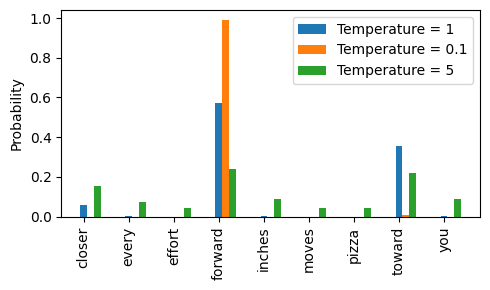

In [90]:
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")


ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.png")
plt.show()

Temperature greater than 1 will result in more uniformly distributed token probabilities after applying the softmax and the Temperature smaller than 1 will result in more confident distributions after applying hte softmax.

In [91]:
print_sampled_tokens(scaled_probas[2]) # for temperature of 5

Count of sampled token id: tensor([153,  68,  55, 223, 102,  50,  43, 217,  89])
153 * closer
68 * every
55 * effort
223 * forward
102 * inches
50 * moves
43 * pizza
217 * toward
89 * you


## Top-K Sampling

In [92]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(f"Top Logits: {top_logits}")
print(f"Top preds: {top_pos}")

Top Logits: tensor([6.7500, 6.2800, 4.5100])
Top preds: tensor([3, 7, 0])


In [93]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [96]:
new_logits = torch.full_like( # create tensor containing -inf values
   next_token_logits, -torch.inf
)
new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor

In [95]:
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [97]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Generate Text with Control Randomness

In [108]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      # get the minimum value from the logits for all batch here (only one batch)
      min_val = top_logits[:, -1]
      logits = torch.where(logits < min_val, torch.tensor(float("-inf")), logits).to(logits.device)

    if temperature > 0.0:
      logits = logits / temperature

      probs = torch.softmax(logits, dim=-1)

      idx_next = torch.multinomial(probs, num_samples=1)

    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1) # (batch_size, num_tokens + 1)

  return idx

In [109]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text: ", token_ids_to_text(token_ids, tokenizer))

Output text:  Every effort moves you course I looked, my diagnosisI must I saw that lifted the tips of


## Loading and saving model weights in PyTorch

In [110]:
torch.save(model.state_dict(), "model.pth")

In [111]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("./model.pth", map_location=device, weights_only=True))

model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear(in_features=768, out_features=768, bias=False)
        (W_Key): Linear(in_features=768, out_features=768, bias=False)
        (W_Value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Line

It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later:

In [112]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [113]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## Loading PreTrained Weights from OpenAI

In [114]:
import os
import urllib.request

import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination):
    # Send a GET request to download the file

    try:
        with urllib.request.urlopen(url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return

            # Define the block size for reading the file
            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(url)  # Extract filename from URL
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                # Open the destination file in binary write mode
                with open(destination, "wb") as file:
                    # Read the file in chunks and write to destination
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))  # Update progress bar
    except urllib.error.HTTPError:
        s = (
            f"The specified URL ({url}) is incorrect, the internet connection cannot be established,"
            "\nor the requested file is temporarily unavailable.\nPlease visit the following website"
            " for help: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
        print(s)


# Alternative way using `requests`
"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [115]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 168kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.43MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 197kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:20<00:00, 24.9MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.84MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.27MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.22MiB/s]


#### Setting

In [117]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


#### Parameter Key

In [118]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [119]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [120]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [121]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [122]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [124]:
gpt

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear(in_features=768, out_features=768, bias=True)
        (W_Key): Linear(in_features=768, out_features=768, bias=True)
        (W_Value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_skip): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_Query): Linear

In [127]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_Query.weight = assign(
            gpt.trf_blocks[b].att.W_Query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_Key.weight = assign(
            gpt.trf_blocks[b].att.W_Key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_Value.weight = assign(
            gpt.trf_blocks[b].att.W_Value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_Query.bias = assign(
            gpt.trf_blocks[b].att.W_Query.bias, q_b)
        gpt.trf_blocks[b].att.W_Key.bias = assign(
            gpt.trf_blocks[b].att.W_Key.bias, k_b)
        gpt.trf_blocks[b].att.W_Value.bias = assign(
            gpt.trf_blocks[b].att.W_Value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [129]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=100,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle you lost due to an encounter on an opponent's power you controlled

If you've defeated 10-20% of the level you can choose this and win it

This effect is reset every time you lose a character by changing stats after 10 seconds

Note that, although you could only select a certain number of levels to choose you can also change levels by playing
